In [1]:
import os
import json
import datetime

import tqdm
import glob
from imp import reload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import normalize
from scipy.optimize import minimize

import deltascope as ds
from statsmodels.stats import multitest

In [2]:
# --------------------------------
# -------- User input ------------
# --------------------------------

# Specify path to exported landmark data
lmpath = glob.glob('*55_landmarks.csv')
binpath = glob.glob('*55_landmarks_bins.json')
print(lmpath,binpath)

# Pick the correct path from the list
lmpath = lmpath[0]
binpath = binpath[0]

['09-11-15-55_landmarks.csv'] ['09-11-15-55_landmarks_bins.json']


In [3]:
# Load landmarks from csv
oldlm = pd.read_csv(lmpath)

In [4]:
# Load landmark bins 
with open(binpath,'r') as f:
    bins = json.load(f)
acbins = bins['acbins']
tbins = bins['tbins']

In [5]:
colors = ['#41ab5d','#ef3b2c','#00441b','#67000d']
tarr = np.round(tbins,2)
xarr = np.round(acbins,2)
tpairs = [[tarr[4],tarr[0]],[tarr[5],tarr[1]],[tarr[6],tarr[2]],[tarr[7],tarr[3]]]

# Restructure Data

We will sort landmark data according to stype and organize it in a two tiered dictionary according to sample type (s) and channel (c).

In [6]:
oldlm.stype.unique()

array(['wt-AT', 'wt-ZRF', 'yot-AT', 'yot-ZRF', 'hss1a-AT', 'hss1a-ZRF',
       'hss1ayot-AT', 'hss1ayot-ZRF'], dtype=object)

In [7]:
Dlm = {}
for stype in tqdm.tqdm(oldlm.stype.unique()):
    # These two lines may need to be modified based on stype structure
    s = stype.split('-')[0]
    c = stype.split('-')[-1]
    
    # Add sample type dictionary if not already present
    if s not in Dlm.keys():
        Dlm[s] = {}
    
    # Save sample specific landmark data to dictionary
    Dlm[s][c] = oldlm[oldlm.stype==stype]

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1334.12it/s]


# Set up graph data

In [8]:
comp = [['wt','yot'],['wt','hss1a'],['wt','hss1ayot'],['yot','hss1a'],['yot','hss1ayot'],['hss1a','hss1ayot']]

In [9]:
qc1 = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
qc2 = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']

In [10]:
gdata = {}
for i,a in enumerate(Dlm.keys()):
    gdata[a] = {}
    
    gdata[a]['AT'] = ds.graphData(Dlm[a]['AT'][Dlm[a]['AT'].stype==a+'-'+'AT'],qc1[i])
    gdata[a]['ZRF'] = ds.graphData(Dlm[a]['ZRF'][Dlm[a]['ZRF'].stype==a+'-'+'ZRF'],qc1[i])

In [11]:
Lstype = list(Dlm.keys())
Lstype

['wt', 'yot', 'hss1a', 'hss1ayot']

In [19]:
crop = 40 # microns
legend = False
save = True
a = 0.3
pthresh = 0.01

## Individual at/zrf graphs

### R

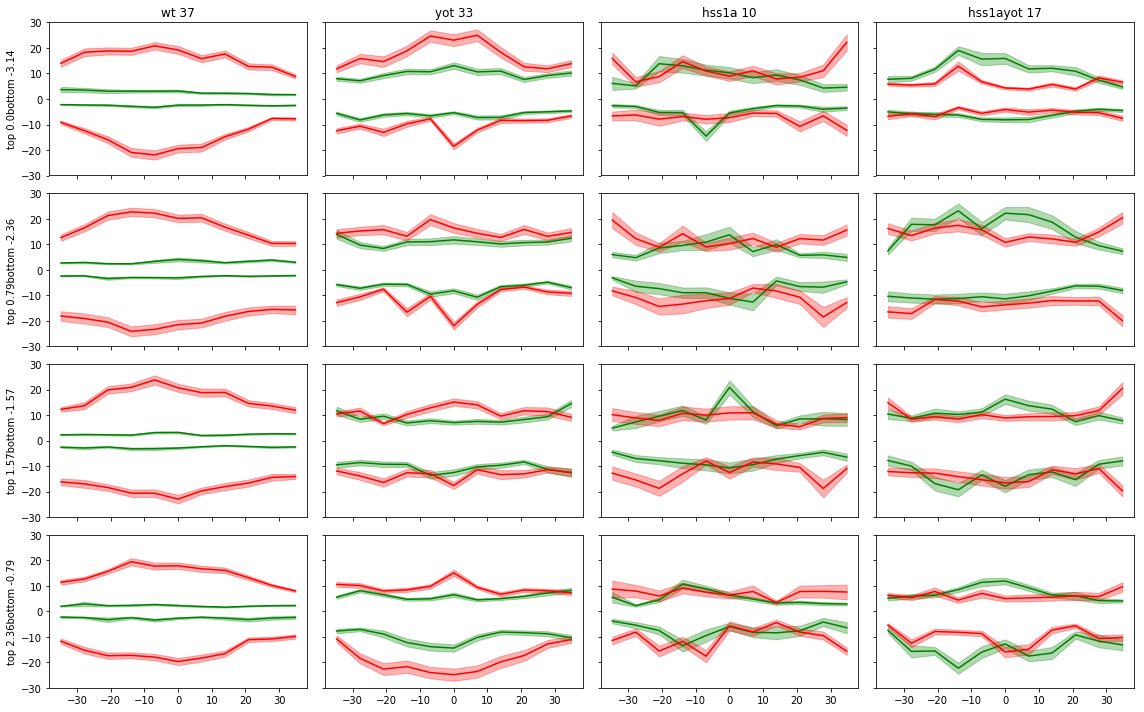

In [13]:
fig,axr = plt.subplots(4,4,figsize=(16,10),sharey=True,sharex=True)

if crop is not None:
    mask = np.where((xarr>-crop)&(xarr<crop) == True)[0]
    xmin = mask.min()
    xmax = mask.max()
    xarrcr = xarr[xmin:xmax+1]
else:
    xarrcr = xarr

for j in range(4):
    ak = Lstype[j]
    go = gdata[ak]['AT']
    go.prepare_data(xarrcr,tarr,'r')
    
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,j].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color='g',zorder=1)
        axr[i,j].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color='g',zorder=1)

        axr[i,j].plot(xarrcr,go.avg[:,ti1],c='g',zorder=2,label='AT')
        axr[i,j].plot(xarrcr,-go.avg[:,ti2],c='g',zorder=2)
        
    go = gdata[ak]['ZRF']
    go.prepare_data(xarrcr,tarr,'r')
    
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,j].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color='r',zorder=1)
        axr[i,j].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color='r',zorder=1)

        axr[i,j].plot(xarrcr,go.avg[:,ti1],c='r',zorder=2,label='ZRF')
        axr[i,j].plot(xarrcr,-go.avg[:,ti2],c='r',zorder=2)
        
        if legend is not False:
            axr[i,j].legend()
            axr[i,j].set_yticklabels([])
            axr[i,j].set_xticklabels([])
        
        # Add theta labels
        axr[i,0].set_ylabel('top '+str(p[0])+'bottom '+str(p[1]))
        
    axr[0,j].set_title(ak+' '+str(go.arr.shape[-1]))
    
plt.tight_layout()

if legend is not False:
    plt.suptitle('AT/ZRF R distance for each sample type')
    
tstamp = datetime.datetime.now().strftime('%Y-%m-%d')

if save:
    fig.savefig(tstamp+'_s1a-indv-r.pdf')

### Pts

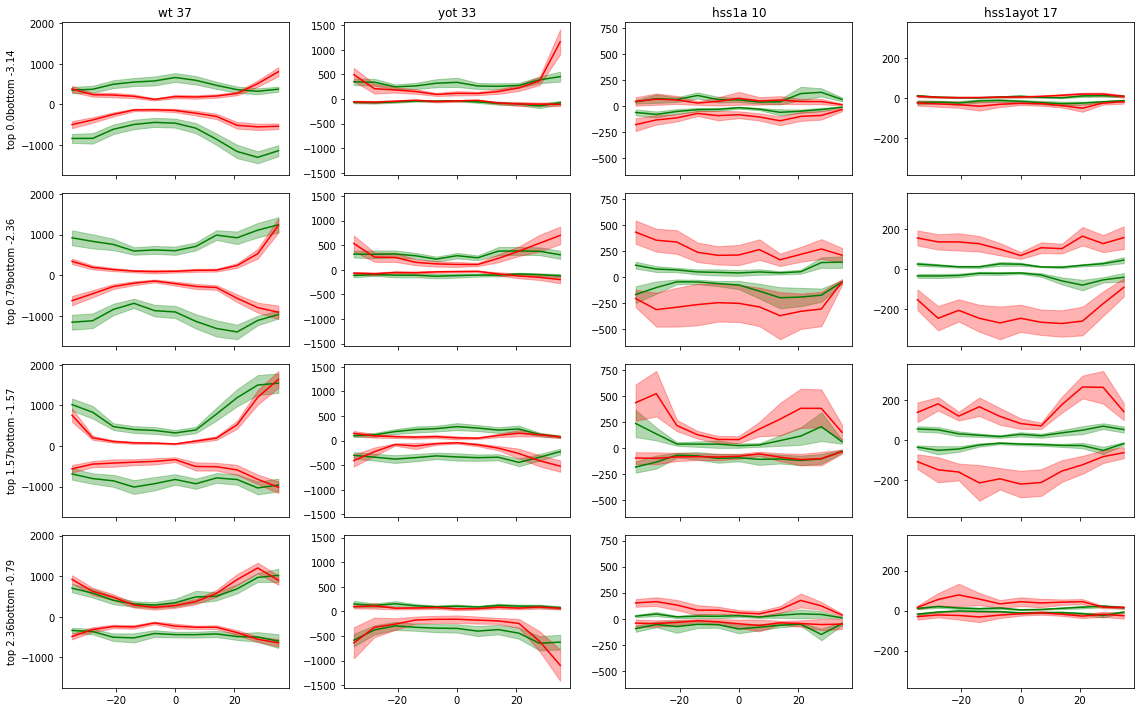

In [14]:
fig,axr = plt.subplots(4,4,figsize=(16,10),sharey='col',sharex=True)

if crop is not None:
    mask = np.where((xarr>-crop)&(xarr<crop) == True)[0]
    xmin = mask.min()
    xmax = mask.max()
    xarrcr = xarr[xmin:xmax+1]
else:
    xarrcr = xarr

for j in range(4):
    ak = Lstype[j]
    go = gdata[ak]['AT']
    go.prepare_data(xarrcr,tarr,'pts')
    
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,j].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color='g',zorder=1)
        axr[i,j].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color='g',zorder=1)

        axr[i,j].plot(xarrcr,go.avg[:,ti1],c='g',zorder=2,label='AT')
        axr[i,j].plot(xarrcr,-go.avg[:,ti2],c='g',zorder=2)
        
    go = gdata[ak]['ZRF']
    go.prepare_data(xarrcr,tarr,'pts')
    
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,j].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color='r',zorder=1)
        axr[i,j].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color='r',zorder=1)

        axr[i,j].plot(xarrcr,go.avg[:,ti1],c='r',zorder=2,label='ZRF')
        axr[i,j].plot(xarrcr,-go.avg[:,ti2],c='r',zorder=2)
        
        if legend is not False:
            axr[i,j].legend()
            axr[i,j].set_yticklabels([])
            axr[i,j].set_xticklabels([])
        
        # Add theta labels
        axr[i,0].set_ylabel('top '+str(p[0])+'bottom '+str(p[1]))
        
    axr[0,j].set_title(ak+' '+str(go.arr.shape[-1]))
    
plt.tight_layout()

tstamp = datetime.datetime.now().strftime('%Y-%m-%d')

if save:
    fig.savefig(tstamp+'_s1a-indv-pts.pdf')

## AT R comparison

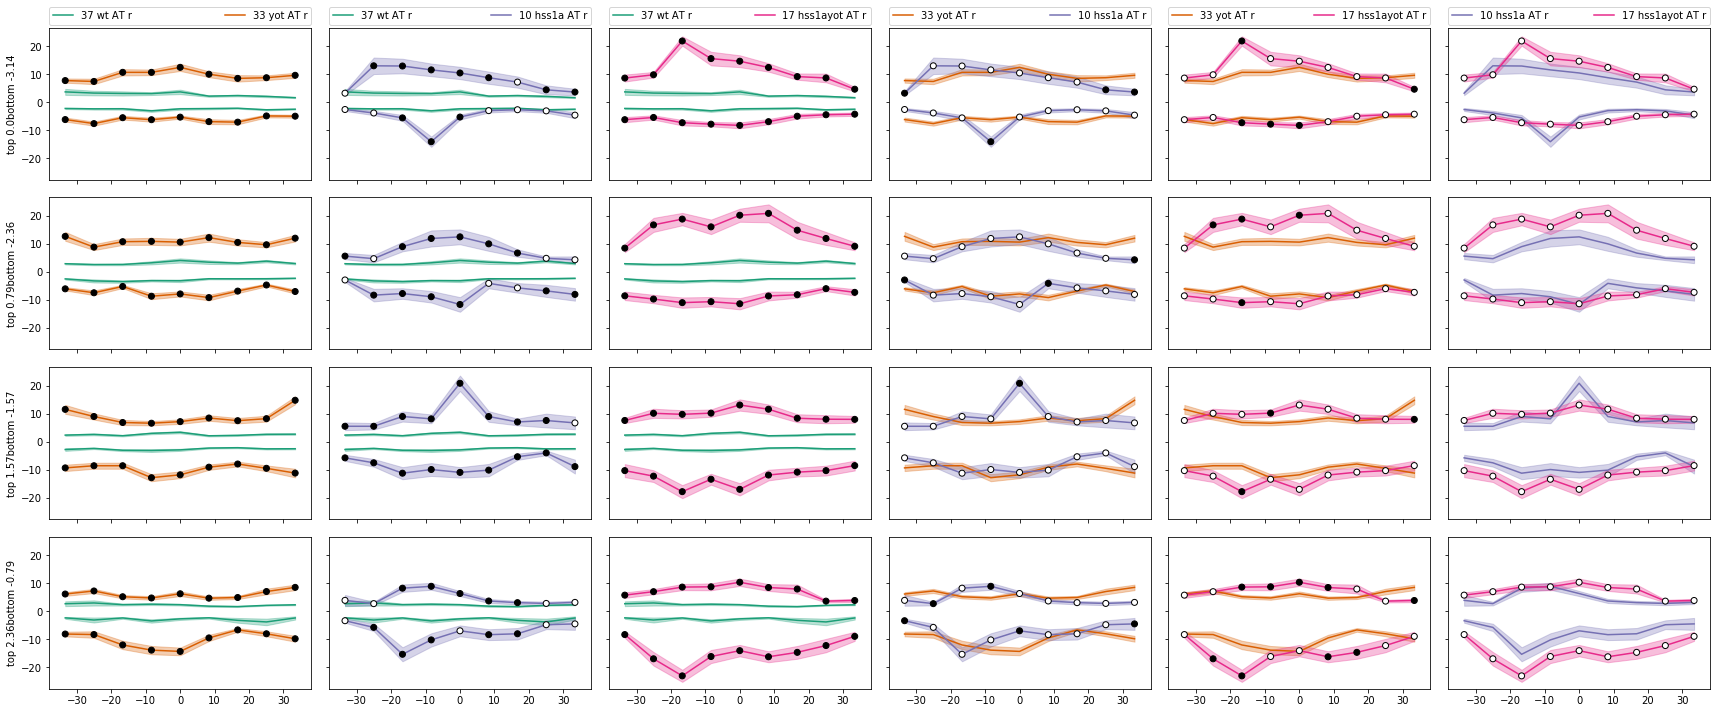

In [20]:
channel = 'AT'
dtype = 'r'

fig,axr = plt.subplots(4,6,figsize=(24,10),sharey=True,sharex=True)

if crop is not None:
    mask = np.where((xarr>-crop)&(xarr<crop) == True)[0]
    xmin = mask.min()
    xmax = mask.max()
    xarrcr = xarr[xmin:xmax+1]
else:
    xarrcr = xarr

for n,c in enumerate(comp):
    go1 = gdata[c[0]][channel]
    go1.prepare_data(xarrcr,tarr,dtype)
    go2 = gdata[c[1]][channel]
    go2.prepare_data(xarrcr,tarr,dtype)
    
    parr =[]
    for i in range(len(go1.arr_masked[:,1,1])):
        R =[]
        for j in range(len(go1.arr_masked[1,:,1])-1):
            try:
                r = stats.kruskal(go1.arr_masked[i,j,:], go2.arr_masked[i,j,:], nan_policy = 'omit')[1]
                R.append(r)
            except:
                r=np.NaN
                R.append(r)
        parr.append(R)
    parr=np.asarray(parr)
    parr = np.reshape(parr, ((1,-1)))
    multi = multitest.multipletests(parr[0], alpha =.01, method='fdr_tsbh')[1]
    multi[multi<.05]=0
    multi[multi>=.05]=1
    parr = multi.reshape(len(go1.arr_masked[:,1,1]),8)
    
    go = go1
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,n].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color=go.c,zorder=1)
        axr[i,n].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color=go.c,zorder=1)

        axr[i,n].plot(xarrcr,go.avg[:,ti1],c=go.c,zorder=2,label='{} {} {} {}'.format(go.arr.shape[-1],c[0],channel,dtype))
        axr[i,n].plot(xarrcr,-go.avg[:,ti2],c=go.c,zorder=2)
        
    go = go2
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,n].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color=go.c,zorder=1)
        axr[i,n].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color=go.c,zorder=1)

        axr[i,n].plot(xarrcr,go.avg[:,ti1],c=go.c,zorder=2,label='{} {} {} {}'.format(go.arr.shape[-1],c[1],channel,dtype))
        axr[i,n].plot(xarrcr,-go.avg[:,ti2],c=go.c,zorder=2)
        
        axr[i,n].scatter(xarrcr,go.avg[:,ti1],c=parr[:,ti1],cmap='Greys_r',zorder=3,vmin=0,vmax=1,edgecolor='k')
        axr[i,n].scatter(xarrcr,-go.avg[:,ti2],c=parr[:,ti2],cmap='Greys_r',zorder=3,vmin=0,vmax=1,edgecolor='k')
        
        axr[0,n].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)

        if legend is not False:
            axr[i,j].legend()
            axr[i,j].set_yticklabels([])
            axr[i,j].set_xticklabels([])
        
        # Add theta labels
        axr[i,0].set_ylabel('top '+str(p[0])+'bottom '+str(p[1]))
    
plt.tight_layout()

tstamp = datetime.datetime.now().strftime('%Y-%m-%d')

if save:
    fig.savefig(tstamp+'_s1a-comparison-{}-{}.pdf'.format(channel,dtype))

## AT Pts comparison

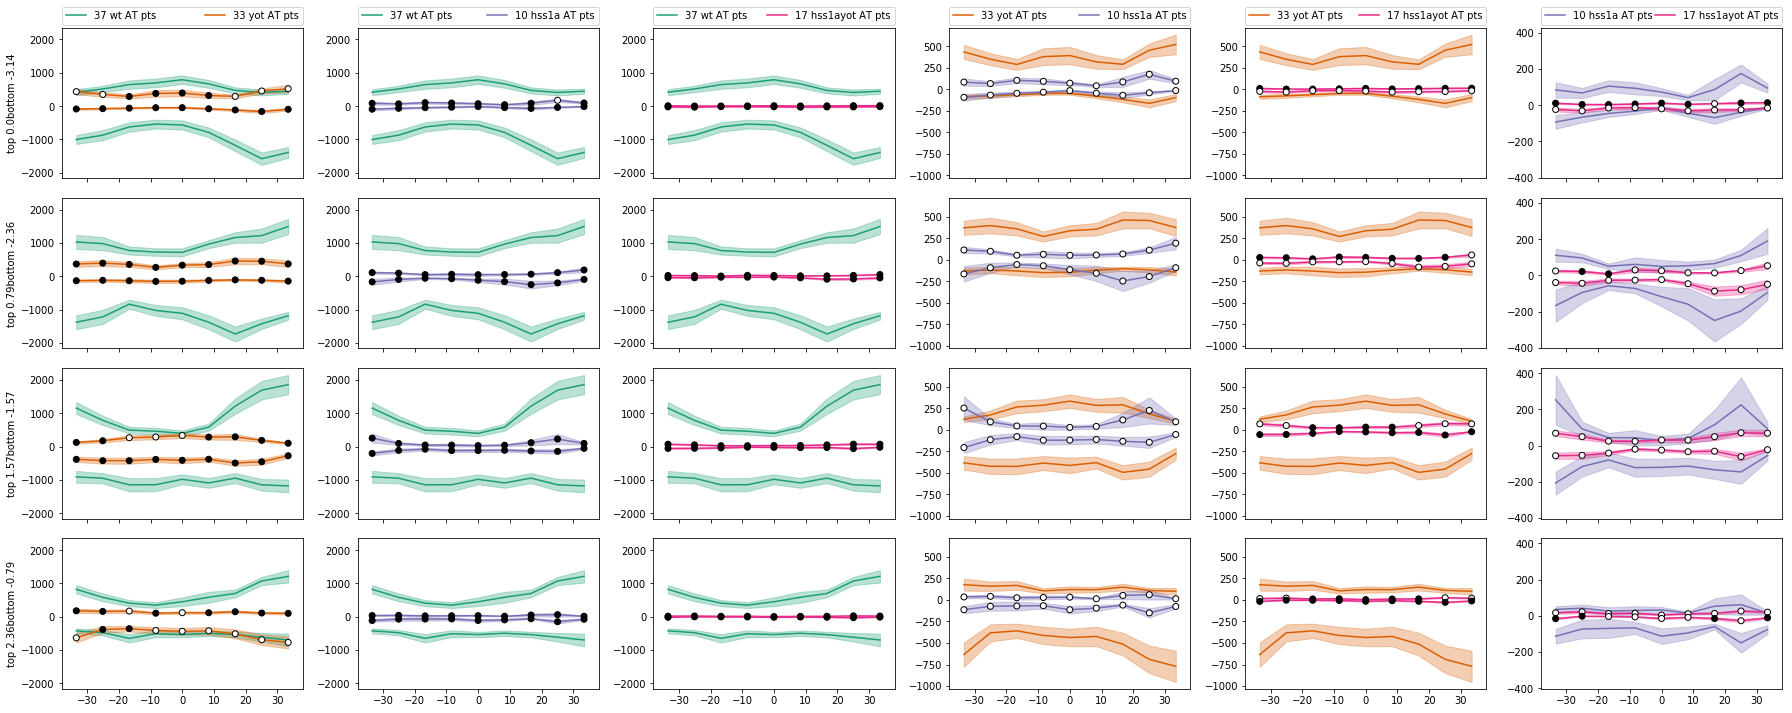

In [21]:
channel = 'AT'
dtype = 'pts'

fig,axr = plt.subplots(4,6,figsize=(25,10),sharey='col',sharex=True)

if crop is not None:
    mask = np.where((xarr>-crop)&(xarr<crop) == True)[0]
    xmin = mask.min()
    xmax = mask.max()
    xarrcr = xarr[xmin:xmax+1]
else:
    xarrcr = xarr

for n,c in enumerate(comp):
    go1 = gdata[c[0]][channel]
    go1.prepare_data(xarrcr,tarr,dtype)
    go2 = gdata[c[1]][channel]
    go2.prepare_data(xarrcr,tarr,dtype)
    
    parr =[]
    for i in range(len(go1.arr_masked[:,1,1])):
        R =[]
        for j in range(len(go1.arr_masked[1,:,1])-1):
            try:
                r = stats.kruskal(go1.arr_masked[i,j,:], go2.arr_masked[i,j,:], nan_policy = 'omit')[1]
                R.append(r)
            except:
                r=np.NaN
                R.append(r)
        parr.append(R)
    parr=np.asarray(parr)
    parr = np.reshape(parr, ((1,-1)))
    multi = multitest.multipletests(parr[0], alpha =.01, method='fdr_tsbh')[1]
    multi[multi<.05]=0
    multi[multi>=.05]=1
    parr = multi.reshape(len(go1.arr_masked[:,1,1]),8)
    
    go = go1
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,n].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color=go.c,zorder=1)
        axr[i,n].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color=go.c,zorder=1)

        axr[i,n].plot(xarrcr,go.avg[:,ti1],c=go.c,zorder=2,label='{} {} {} {}'.format(go.arr.shape[-1],c[0],channel,dtype))
        axr[i,n].plot(xarrcr,-go.avg[:,ti2],c=go.c,zorder=2)
        
    go = go2
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,n].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color=go.c,zorder=1)
        axr[i,n].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color=go.c,zorder=1)

        axr[i,n].plot(xarrcr,go.avg[:,ti1],c=go.c,zorder=2,label='{} {} {} {}'.format(go.arr.shape[-1],c[1],channel,dtype))
        axr[i,n].plot(xarrcr,-go.avg[:,ti2],c=go.c,zorder=2)
        
        axr[i,n].scatter(xarrcr,go.avg[:,ti1],c=parr[:,ti1],cmap='Greys_r',zorder=3,vmin=0,vmax=1,edgecolor='k')
        axr[i,n].scatter(xarrcr,-go.avg[:,ti2],c=parr[:,ti2],cmap='Greys_r',zorder=3,vmin=0,vmax=1,edgecolor='k')
        
        axr[0,n].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)

        if legend is not False:
            axr[i,j].legend()
            axr[i,j].set_yticklabels([])
            axr[i,j].set_xticklabels([])
        
        # Add theta labels
        axr[i,0].set_ylabel('top '+str(p[0])+'bottom '+str(p[1]))
    
plt.tight_layout()

tstamp = datetime.datetime.now().strftime('%Y-%m-%d')

if save:
    fig.savefig(tstamp+'_s1a-comparison-{}-{}.pdf'.format(channel,dtype))

## Comparison zrf R

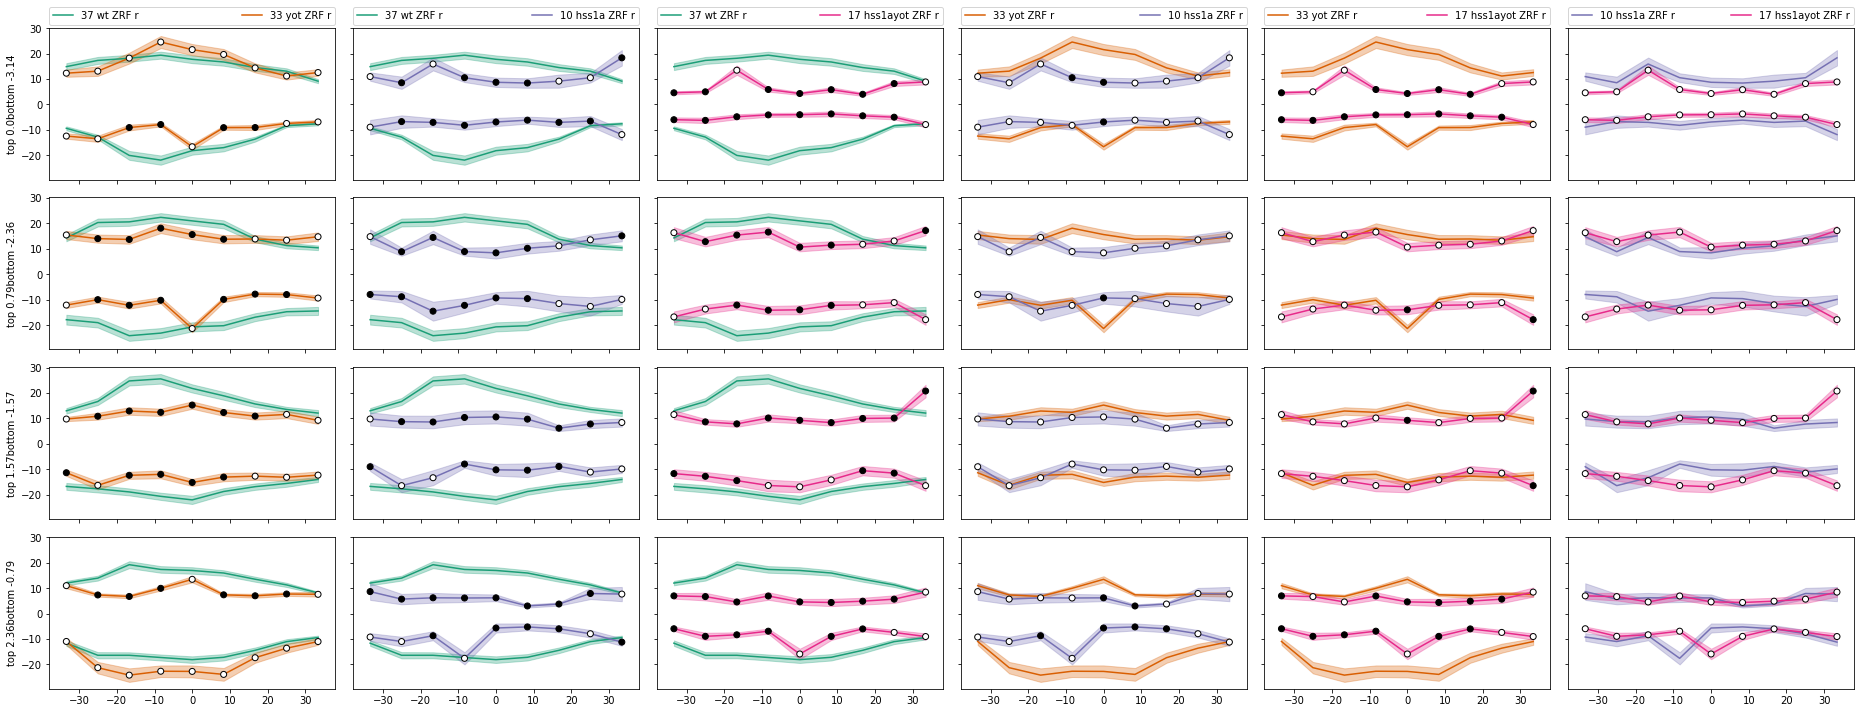

In [22]:
channel = 'ZRF'
dtype = 'r'

fig,axr = plt.subplots(4,6,figsize=(26,10),sharey=True,sharex=True)

if crop is not None:
    mask = np.where((xarr>-crop)&(xarr<crop) == True)[0]
    xmin = mask.min()
    xmax = mask.max()
    xarrcr = xarr[xmin:xmax+1]
else:
    xarrcr = xarr

for n,c in enumerate(comp):
    go1 = gdata[c[0]][channel]
    go1.prepare_data(xarrcr,tarr,dtype)
    go2 = gdata[c[1]][channel]
    go2.prepare_data(xarrcr,tarr,dtype)
    
    parr =[]
    for i in range(len(go1.arr_masked[:,1,1])):
        R =[]
        for j in range(len(go1.arr_masked[1,:,1])-1):
            try:
                r = stats.kruskal(go1.arr_masked[i,j,:], go2.arr_masked[i,j,:], nan_policy = 'omit')[1]
                R.append(r)
            except:
                r=np.NaN
                R.append(r)
        parr.append(R)
    parr=np.asarray(parr)
    parr = np.reshape(parr, ((1,-1)))
    multi = multitest.multipletests(parr[0], alpha =.01, method='fdr_tsbh')[1]
    multi[multi<.05]=0
    multi[multi>=.05]=1
    parr = multi.reshape(len(go1.arr_masked[:,1,1]),8)
    
    go = go1
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,n].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color=go.c,zorder=1)
        axr[i,n].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color=go.c,zorder=1)

        axr[i,n].plot(xarrcr,go.avg[:,ti1],c=go.c,zorder=2,label='{} {} {} {}'.format(go.arr.shape[-1],c[0],channel,dtype))
        axr[i,n].plot(xarrcr,-go.avg[:,ti2],c=go.c,zorder=2)
        
    go = go2
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,n].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color=go.c,zorder=1)
        axr[i,n].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color=go.c,zorder=1)

        axr[i,n].plot(xarrcr,go.avg[:,ti1],c=go.c,zorder=2,label='{} {} {} {}'.format(go.arr.shape[-1],c[1],channel,dtype))
        axr[i,n].plot(xarrcr,-go.avg[:,ti2],c=go.c,zorder=2)
        
        axr[i,n].scatter(xarrcr,go.avg[:,ti1],c=parr[:,ti1],cmap='Greys_r',zorder=3,vmin=0,vmax=1,edgecolor='k')
        axr[i,n].scatter(xarrcr,-go.avg[:,ti2],c=parr[:,ti2],cmap='Greys_r',zorder=3,vmin=0,vmax=1,edgecolor='k')
        
        axr[0,n].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)
        
        if legend is not False:
            axr[i,j].legend()
            axr[i,j].set_yticklabels([])
            axr[i,j].set_xticklabels([])
        
        # Add theta labels
        axr[i,0].set_ylabel('top '+str(p[0])+'bottom '+str(p[1]))
    
plt.tight_layout()

tstamp = datetime.datetime.now().strftime('%Y-%m-%d')

if save:
    fig.savefig(tstamp+'_s1a-comparison-{}-{}.pdf'.format(channel,dtype))

## comparison zrf pts

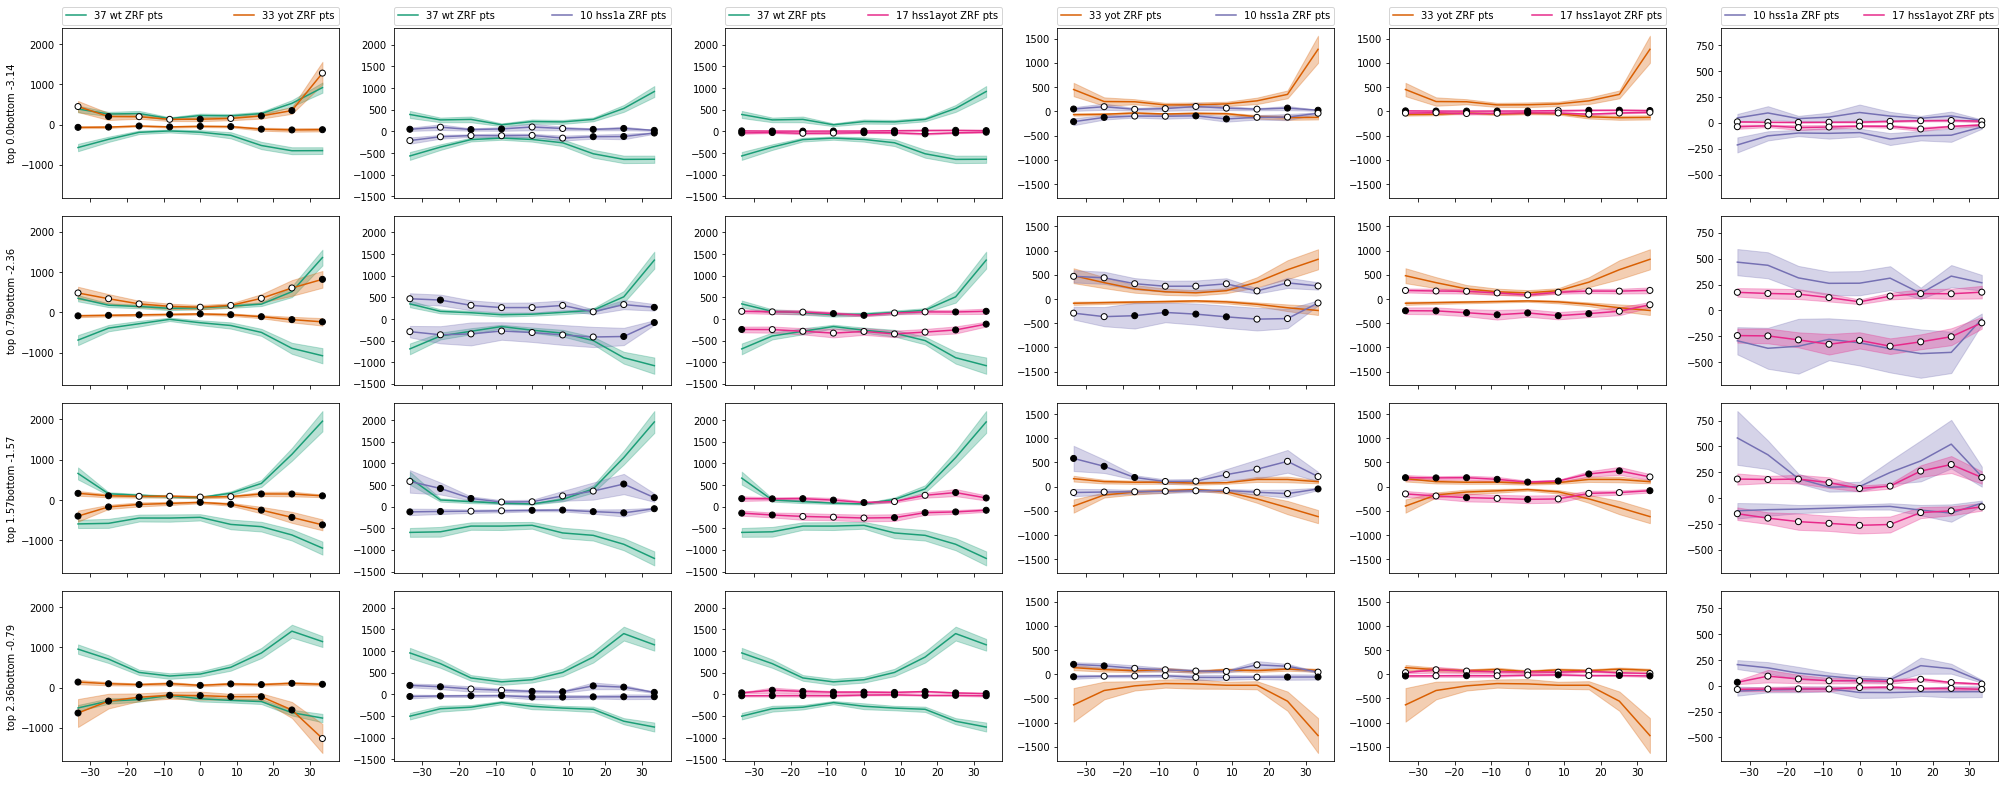

In [23]:
channel = 'ZRF'
dtype = 'pts'

fig,axr = plt.subplots(4,6,figsize=(28,11),sharey='col',sharex=True)

if crop is not None:
    mask = np.where((xarr>-crop)&(xarr<crop) == True)[0]
    xmin = mask.min()
    xmax = mask.max()
    xarrcr = xarr[xmin:xmax+1]
else:
    xarrcr = xarr

for n,c in enumerate(comp):
    go1 = gdata[c[0]][channel]
    go1.prepare_data(xarrcr,tarr,dtype)
    go2 = gdata[c[1]][channel]
    go2.prepare_data(xarrcr,tarr,dtype)
    
    parr =[]
    for i in range(len(go1.arr_masked[:,1,1])):
        R =[]
        for j in range(len(go1.arr_masked[1,:,1])-1):
            try:
                r = stats.kruskal(go1.arr_masked[i,j,:], go2.arr_masked[i,j,:], nan_policy = 'omit')[1]
                R.append(r)
            except:
                r=np.NaN
                R.append(r)
        parr.append(R)
    parr=np.asarray(parr)
    parr = np.reshape(parr, ((1,-1)))
    multi = multitest.multipletests(parr[0], alpha =.01, method='fdr_tsbh')[1]
    multi[multi<.05]=0
    multi[multi>=.05]=1
    parr = multi.reshape(len(go1.arr_masked[:,1,1]),8)
    
    go = go1
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,n].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color=go.c,zorder=1)
        axr[i,n].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color=go.c,zorder=1)

        axr[i,n].plot(xarrcr,go.avg[:,ti1],c=go.c,zorder=2,label='{} {} {} {}'.format(go.arr.shape[-1],c[0],channel,dtype))
        axr[i,n].plot(xarrcr,-go.avg[:,ti2],c=go.c,zorder=2)
        
    go = go2
    for i,p in enumerate(tpairs):
        ti1 = np.where(tarr==p[0])[0][0]
        ti2 = np.where(tarr==p[1])[0][0]

        axr[i,n].fill_between(xarrcr,go.avg[:,ti1]+go.sem[:,ti1],go.avg[:,ti1]-go.sem[:,ti1],alpha=a,color=go.c,zorder=1)
        axr[i,n].fill_between(xarrcr,-go.avg[:,ti2]+go.sem[:,ti2],-go.avg[:,ti2]-go.sem[:,ti2],alpha=a,color=go.c,zorder=1)

        axr[i,n].plot(xarrcr,go.avg[:,ti1],c=go.c,zorder=2,label='{} {} {} {}'.format(go.arr.shape[-1],c[1],channel,dtype))
        axr[i,n].plot(xarrcr,-go.avg[:,ti2],c=go.c,zorder=2)
        
        axr[i,n].scatter(xarrcr,go.avg[:,ti1],c=parr[:,ti1],cmap='Greys_r',zorder=3,vmin=0,vmax=1,edgecolor='k')
        axr[i,n].scatter(xarrcr,-go.avg[:,ti2],c=parr[:,ti2],cmap='Greys_r',zorder=3,vmin=0,vmax=1,edgecolor='k')
        
        axr[0,n].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.)

        if legend is not False:
            axr[i,j].legend()
            axr[i,j].set_yticklabels([])
            axr[i,j].set_xticklabels([])
        
        # Add theta labels
        axr[i,0].set_ylabel('top '+str(p[0])+'bottom '+str(p[1]))
    
plt.tight_layout()

tstamp = datetime.datetime.now().strftime('%Y-%m-%d')

if save:
    fig.savefig(tstamp+'_s1a-comparison-{}-{}.pdf'.format(channel,dtype))